In [1]:
import os
import sys
import torch
import configparser
import numpy as np
import pandas as pd
import torch_geometric as tg
import matplotlib.pyplot as plt

sys.path.append('..')
from model import SCHetNet, schetnet_train, schetnet_valid
from dataset import SCHetData, SCHetDataset


torch.manual_seed(0)
np.random.seed(0)

# ECSOS Simulations

In [22]:
ecsos_results = np.loadtxt('./ecsos_hydro_results.txt')
ecsos_errors = np.abs(ecsos_results[1:] - ecsos_results[0]).mean(axis=1)
reaction_cfg = configparser.ConfigParser()
reaction_cfg.read('../data/raw_dir/hydro/reactions.cfg')
radical = []
# for idx in (-ecsos_errors).argsort()[:50]:
    # reaction = reaction_cfg.get('reaction_%d' % (idx), 'reaction')
    # for s in reaction.split('>')[0].split('+'):
    #     s = s.replace('1*', '')
    #     if 'J' in s and s not in radical:
    #         radical.append(s)
    # for s in reaction.split('>')[1].split('+'):
    #     s = s.replace('1*', '')
    #     if 'J' in s and s not in radical:
    #         radical.append(s)
    # print('%-3d' % (idx + 1), end='  ')
    # print(reaction_cfg.get('reaction_%d' % (idx), 'reaction'))
# print(radical)
print(' '.join(((-ecsos_errors).argsort()[:50]).astype(str)))
key_reactions_indices = (-ecsos_errors).argsort()[:50]

28 126 39 216 38 157 30 339 40 15 98 45 131 9 228 10 195 58 97 4 44 129 219 220 125 17 162 323 230 259 314 65 42 341 226 218 3 25 32 13 163 43 288 296 27 199 285 160 340 41


In [17]:
species_cfg = configparser.ConfigParser()
species_cfg.read('../data/raw_dir/hydro/mass_properties.cfg')
species = []
for section in species_cfg.sections():
    s = species_cfg.get(section, 'name')
    species.append(s)
print([s for s in species if 'J' in s and s not in radical])

['C6H11J(184)', 'C5H11J(58)', 'C5H9J(209)', 'C4H7J(34)', 'C6H11J(230)', 'C6H11J(79)']


# Visualization

In [38]:
dataset = SCHetDataset('../data', 'hydro', mode='test')
model = SCHetNet(10, 8, 6, 2)
model.load_state_dict(torch.load('../ckpt/schetnet_6_2.ckpt'))
data = dataset[10]
species_x = data.species_x
reactions_x = data.reactions_x
edge_index = data.edge_index
s2r_edge_index = edge_index[:, edge_index[0] < edge_index[1]]
r2s_edge_index = edge_index[:, edge_index[0] > edge_index[1]]
y = data.y
y_index = data.y_index
y_gt = np.zeros((model.num_s + model.num_r))
y_gt[y_index] = y
species_y = model.forward(species_x, reactions_x, edge_index)

num_nodes = model.num_s + model.num_r
r2s_atts = np.zeros((model.num_layers, num_nodes, num_nodes))
s2r_atts = np.zeros((model.num_layers, num_nodes, num_nodes))
for i in range(model.num_layers):
    for (src, dst), weight in zip(
        model._r2s_edge_index[i].transpose(1, 0).detach(), model._r2s_att[i]):
        r2s_atts[i, src, dst] = weight
for i in range(model.num_layers):
    for (src, dst), weight in zip(
        model._s2r_edge_index[i].transpose(1, 0).detach(), model._s2r_att[i]):
        s2r_atts[i, src, dst] = weight
imp = np.dot(y_gt, r2s_atts[1].T)
imp = np.dot(imp, s2r_atts[1])
imp = np.dot(imp, r2s_atts[0].T)
# imp = np.dot(imp, s2r_atts[0])

In [39]:
imp.sum()

91.013603179373

In [57]:
' '.join([str(i) for i in range(1, 343) if i != 29])

'1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 27

In [20]:
order = (-model.attention()[39:].flatten()).argsort()
torch.where(order == 38)

(tensor([205]),)

In [9]:
order1 = (-reactions_y.detach().flatten().numpy()).argsort()
for reaction_idx in key_reactions_indices:
    print('%-3d:  %3d' % (reaction_idx, np.where(order1 == reaction_idx)[0]))

28 :   42
126:   48
39 :    1
216:   41
38 :   19
157:   47
30 :  138
339:    9
40 :   18
15 :   81
98 :   68
45 :   36
131:   58
9  :   71
228:   43
10 :   90
195:   61
58 :  242
97 :   50
4  :  131
44 :   35
129:   54
219:   51
220:  209
125:  150
17 :   62
162:   49
323:  300
230:  226
259:  197
314:  265
65 :  144
42 :   14
341:  333
226:  230
218:  141
3  :   74
25 :   80
32 :   56
13 :  121
163:   66
43 :   17
288:  337
296:  269
27 :  130
199:  133
285:  271
160:   57
340:  332
41 :    4


In [30]:
order1 = (-r2s_imp3[model.num_species:]).argsort()
for reaction_idx in key_reactions_indices:
    print('%-3d:  %3d' % (reaction_idx, np.where(order1 == reaction_idx)[0]))

for _y_index in y_index:
    imp = atts[-1, model.num_species:, _y_index]

28 :   30
126:   39
39 :   15
216:    2
38 :   22
157:   40
30 :   23
339:  330
40 :   24
15 :  262
98 :  180
45 :   27
131:   54
9  :  205
228:   34
10 :  228
195:   26
58 :  289
97 :  266
4  :   14
44 :   41
129:  154
219:  158
220:   20
125:   52
17 :  136
162:   57
323:  182
230:  333
259:  341
314:    1
65 :   76
42 :   13
341:  115
226:   49
218:    6
3  :  183
25 :  226
32 :  143
13 :  247
163:   25
43 :  267
288:  116
296:  134
27 :   33
199:  220
285:  286
160:  159
340:   70
41 :    3


In [6]:
for name, weight in zip(dataset.species_names, torch.softmax(model.forward(species_x, reactions_x, edge_index), dim=0).flatten().detach().numpy()):
    print(name, weight)

H2O 4.403555e-05
CH4 0.19440083
C2H4 0.332721
C2H6 0.041619506
C2H2 4.403555e-05
C3H6 0.22077417
C3H8 0.028863277
BUT-1 0.00952828
BUT-2 0.02039032
iC4H10 0.004796931
nC4H10 0.0014000476
iC4H8 0.028485253
C4H6 0.08544713
nC5H12 0.015318402
CH3J(14) 0.0018187999
C3H7J(17) 3.1979384e-06
C2H5J(16) 3.1427688e-05
C3H5J(28) 3.3827476e-08
C3H7J(18) 1.1925636e-07
HJ(15) 3.4928014e-06
H2 0.0133661665
C4H7J(23) 3.801746e-07
C4H9J(21) 6.096528e-08
C4H9J(19) 7.941106e-09
C4H9J(22) 4.899069e-09
C4H7J(24) 5.668646e-08
C2H3J(25) 4.007886e-08
C5H9J(60) 1.7905916e-07
C5H9J(208) 3.2955316e-07
C6H11J(184) 1.5270848e-07
C5H8 1.4994763e-05
C5H11J(58) 1.7950418e-09
C5H9J(209) 8.197139e-09
C4H7J(34) 1.6885419e-09
C3H5J(27) 4.403555e-05
C6H11J(230) 1.3058736e-05
C6H11J(79) 2.2257274e-09
C7H12 0.00087021635
C5H9J(61) 1.3129582e-08


In [7]:
r2s_imp_y = np.zeros((num_nodes, ))
r2s_imp_y[y_index] = y
r2s_imp1 = np.dot(r2s_imp_y, atts[-1].T)
r2s_imp2 = np.dot(r2s_imp1, atts[-2].T)
r2s_imp3 = np.dot(r2s_imp2, atts[-3].T)
r2s_imp = r2s_imp1 + r2s_imp2 + r2s_imp3

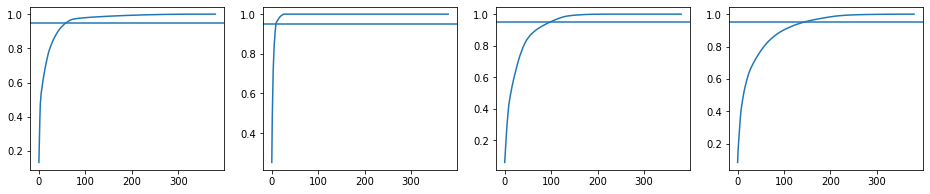

In [25]:
plt.figure(figsize=(16, 3))
plt.subplot(1, 4, 1)
plt.plot(r2s_imp3[(-r2s_imp3).argsort()].cumsum() / r2s_imp3.sum())
plt.axhline(0.95)
plt.subplot(1, 4, 2)
plt.plot(r2s_imp2[(-r2s_imp2).argsort()].cumsum() / r2s_imp2.sum())
plt.axhline(0.95)
plt.subplot(1, 4, 3)
plt.plot(r2s_imp1[(-r2s_imp1).argsort()].cumsum() / r2s_imp1.sum())
plt.axhline(0.95)
plt.subplot(1, 4, 4)
plt.plot(r2s_imp[(-r2s_imp).argsort()].cumsum() / r2s_imp.sum())
plt.axhline(0.95)

In [14]:
(next(iter(loader)).batch == 1).sum()

tensor(381)

(array([  5,   6,   7,  13,  80, 303]),)

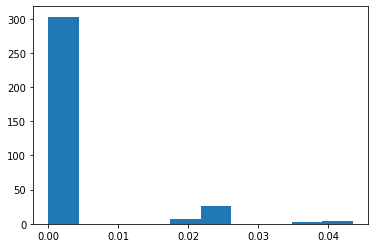

In [48]:
plt.hist(atts[-1, model.num_species:, y_index[2]])
np.where(atts[-1, model.num_species:, y_index[2]] > 0.03)

# Attention

In [24]:
# data
valid_dataset = SCDataset('../data', 'hydro', mode='test')

index = 0
x = valid_dataset[index].x
edge_index = valid_dataset[index].edge_index
edge_attr = valid_dataset[index].edge_attr
y = valid_dataset[index].y
y_index = valid_dataset[index].y_index

s2r_index = (edge_index[0, :] < edge_index[1, :])
r2s_index = (edge_index[0, :] > edge_index[1, :])
s2r_edge_index = edge_index[:, s2r_index]
s2r_edge_attr = edge_attr[s2r_index]
r2s_edge_index = edge_index[:, r2s_index]
r2s_edge_attr = edge_attr[r2s_index]

# model
scnet = SCNet(10, 16, 9)
scnet.load_state_dict(torch.load('../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__0.ckpt'))
x, (_, s2r_att1, s2r_pre_att1) = scnet.s2r_conv1.forward(x, s2r_edge_index, s2r_edge_attr, return_attention_weights=True)
x, (_, r2s_att1, r2s_pre_att1) = scnet.r2s_conv1.forward(x, r2s_edge_index, r2s_edge_attr, return_attention_weights=True)
x, (_, s2r_att2, s2r_pre_att2) = scnet.s2r_conv2.forward(x, s2r_edge_index, s2r_edge_attr, return_attention_weights=True)
x, (_, r2s_att2, r2s_pre_att2) = scnet.r2s_conv2.forward(x, r2s_edge_index, r2s_edge_attr, return_attention_weights=True)

In [25]:
species_num = len(valid_dataset.species_names)
reaction_num = len(x) - species_num

s2r_mat1 = np.zeros((species_num + reaction_num, species_num + reaction_num), dtype=np.float32)
r2s_mat1 = np.zeros((species_num + reaction_num, species_num + reaction_num), dtype=np.float32)
s2r_mat2 = np.zeros((species_num + reaction_num, species_num + reaction_num), dtype=np.float32)
r2s_mat2 = np.zeros((species_num + reaction_num, species_num + reaction_num), dtype=np.float32)

for (src, dst), att in zip(s2r_edge_index.transpose(1, 0).numpy(), s2r_att1.detach().numpy()):
    s2r_mat1[src, dst] = att
for (src, dst), att in zip(r2s_edge_index.transpose(1, 0).numpy(), r2s_att1.detach().numpy()):
    r2s_mat1[src, dst] = att
for (src, dst), att in zip(s2r_edge_index.transpose(1, 0).numpy(), s2r_att2.detach().numpy()):
    s2r_mat2[src, dst] = att
for (src, dst), att in zip(r2s_edge_index.transpose(1, 0).numpy(), r2s_att2.detach().numpy()):
    r2s_mat2[src, dst] = att

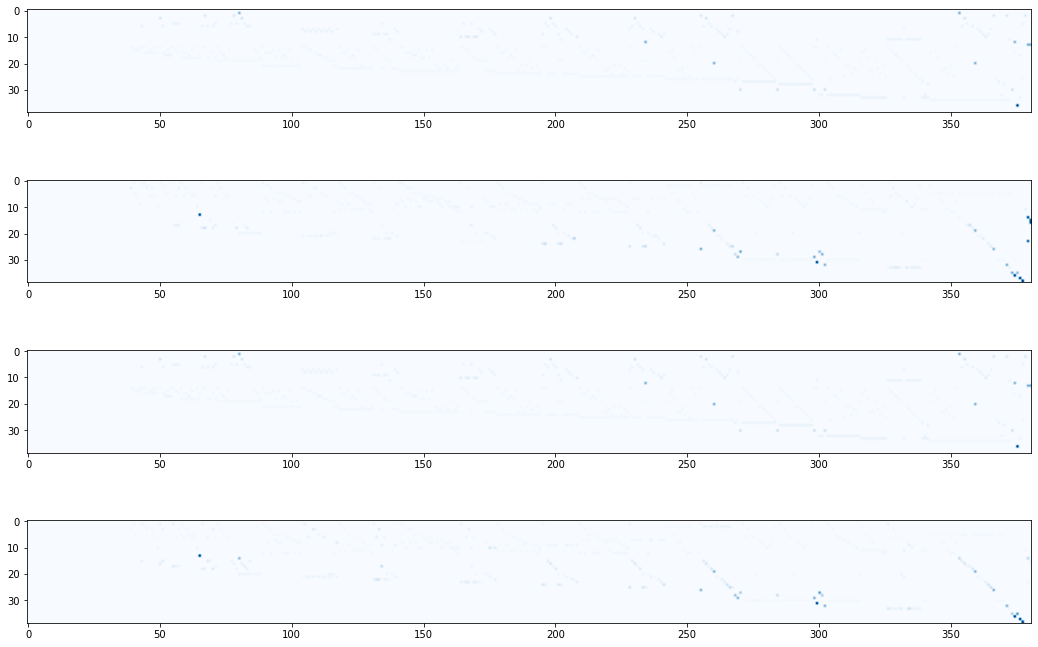

In [26]:
plt.figure(figsize=(18, 12))
plt.subplot(4, 1, 1)
plt.imshow(s2r_mat1[:species_num], cmap='Blues')
plt.subplot(4, 1, 2)
plt.imshow(r2s_mat1[:, :species_num].T, cmap='Blues')
plt.subplot(4, 1, 3)
plt.imshow(s2r_mat2[:species_num], cmap='Blues')
plt.subplot(4, 1, 4)
plt.imshow(r2s_mat2[:, :species_num].T, cmap='Blues')

# Reaction Importance

In [46]:
# data
valid_dataset = SCDataset('../data', 'hydro', mode='test')
index = 0
x = valid_dataset[index].x
edge_index = valid_dataset[index].edge_index
edge_attr = valid_dataset[index].edge_attr
y = valid_dataset[index].y
y_index = valid_dataset[index].y_index
y_all = np.zeros((species_num, ), dtype=np.float32)
y_all[y_index] = 1

# r2s_imp2 = np.dot(y_all / 100, r2s_mat2.T)
# r2s_imp1 = np.dot(np.dot(r2s_imp2, s2r_mat2.T), r2s_mat1.T)
# s2r_imp1 = np.dot(x[:species_num, -1].numpy(), s2r_mat1)
# s2r_imp2 = np.dot(np.dot(s2r_imp1, r2s_mat1), s2r_mat2)

reaction_imp2 = np.dot(x.numpy()[:species_num, -1], s2r_mat2[:species_num])
# species_imp1 = np.dot(reaction_imp1, r2s_mat1[species_num:, :species_num])
# species_imp1 /= species_imp1.sum()
# reaction_imp2 = np.dot(species_imp1, s2r_mat2[:species_num, species_num:])

In [48]:
reaction_imp = reaction_imp2
print((-reaction_imp).argsort()[:50] + 1)
print((-ecsos_errors).argsort()[:50] + 1)

[209 170 241 168 265 364 165 167 171 233  71 201  52  69 198 230 257 355
 260 359  67  44  84  85 381 380 242 207 136 240 266 365 178 132 196 264
 202 137 363 134 133 231 199 356 258  51  82 106 116 108]
[ 29 340 127  40  39 217  31 158  41 229  46 132  99 196  16  11  10  59
   5  98 220  45  18 324 130  43 315  66 163 126 219 342 221 231 260 227
  26 200  33 164 333   4 289  44 286 341 297 161  19  14]


<ipython-input-31-9a7133ed1b72>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(reaction_imp[order].cumsum() / reaction_imp.sum())
<ipython-input-31-9a7133ed1b72>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.axvline(np.where(reaction_imp[order].cumsum() / reaction_imp.sum() > explained_ratio)[0][0])


IndexError: index 0 is out of bounds for axis 0 with size 0

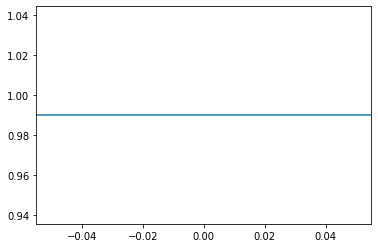

In [31]:
explained_ratio = 0.99

order = (-reaction_imp).argsort()
plt.plot(reaction_imp[order].cumsum() / reaction_imp.sum())
plt.axhline(explained_ratio)
plt.axvline(np.where(reaction_imp[order].cumsum() / reaction_imp.sum() > explained_ratio)[0][0])
plt.ylim(0.0, 1.05)
reserve_reaction_index1 = order[:np.where(reaction_imp[order].cumsum() / reaction_imp.sum() > explained_ratio)[0][0]]

In [38]:
for 

341

In [43]:
reaction_cfg = configparser.ConfigParser()
reaction_cfg.read('../data/raw_dir/hydro/reactions.cfg')
ecsos_reserve_indices = [29, 127,  40, 217,  39, 158,  31, 340,  41,  16,  99,  46, 132,
                         10, 229,  11, 196,  59,  98,   5,  45, 130, 220, 221, 126,  18,
                         163, 324, 231, 260, 315,  66,  43, 342, 227, 219,   4,  26,  33,
                         14, 164,  44, 289, 297,  28, 200, 286, 161, 341,  42]
ecsos_reserve_indices = np.array(ecsos_reserve_indices)
# for ecsos_reserve_index in ecsos_reserve_indices:
#     print(reaction_cfg.get('reaction_%d' % ecsos_reserve_index, 'reaction'), end=' ')
#     print(np.where(reserve_reaction_index1 == (ecsos_reserve_index - 1))[0])
reserve_edge_bool1 = [i in ecsos_reserve_indices + 38 for i in edge_index.numpy().max(axis=0)]

In [34]:
' '.join((reserve_reaction_index1 + 1)[reserve_reaction_index1.argsort()].astype(str).tolist())

'2 3 4 5 7 8 9 10 12 13 14 15 18 19 20 21 22 23 24 25 26 27 28 30 31 32 33 35 37 38 42 43 45 46 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 67 68 69 70 71 73 74 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 128 129 130 131 132 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 159 160 161 162 163 165 166 167 168 169 170 174 175 177 178 180 181 182 183 184 186 187 188 189 191 192 194 199 201 202 203 206 207 208 209 210 211 212 215 218 219 221 222 224 225 226 227 231 234 235 237 239 240 241 242 243 248 251 253 254 255 256 257 269 270 272 273 274 275 276 278 279 280 281 282 283 284 285 286 287 288 289 290 292 294 295 296 297 298 301 302 303 306 307 308 309 310 311 312 315 316 317 320 321 323 324 325 326 336 338 341 342'

# Simplification Step 1

In [48]:
# model
scnet = SCNet(10, 16, 9)

# dataset
train_dataset = SCDataset('../data', 'hydro')
train_loader = tg.data.DataLoader(train_dataset, 32, shuffle=True)
valid_dataset = SCDataset('../data', 'hydro', mode='test')
valid_loader = tg.data.DataLoader(valid_dataset, 32, shuffle=False)

# optimizer
optimizer = torch.optim.Adam(scnet.parameters(), lr=0.001, weight_decay=1e-6)

# train
train_losses = []
valid_losses = []
epochs = 20
tqdm_epoch = range(epochs)
for epoch in tqdm_epoch:
    train_losses.extend(train(scnet, train_loader, optimizer, reserve_edge_bool1))
    valid_losses.extend(valid(scnet, valid_loader, reserve_edge_bool1))
# torch.save(scnet.state_dict(), '../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__1.ckpt')
# json.dump({'train': train_losses, 'valid': valid_losses}, open('../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__1.log', 'w'))

100%|██████████| 16/16 [00:00<00:00, 34.79it/s, valid_loss=2.93]


(0.0, 4.0)

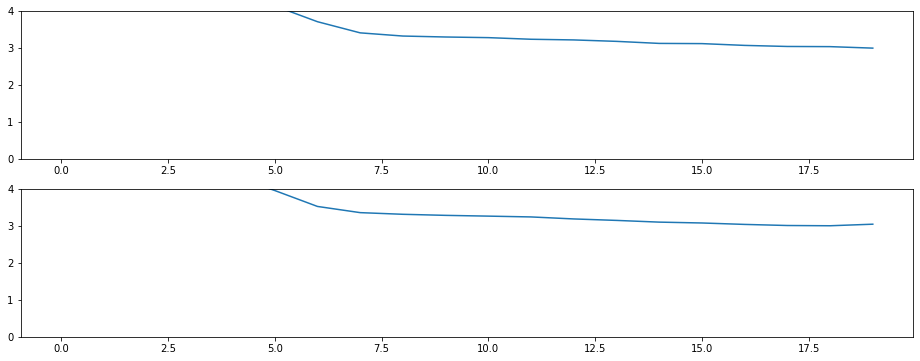

In [50]:
# log = json.load(open('../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__1.log', 'r'))
# train_losses, valid_losses = log['train'], log['valid']
plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.plot(np.array(train_losses).reshape(epochs, -1).mean(axis=-1), label='Training loss')
plt.ylim(0, 4)
plt.subplot(2, 1, 2)
plt.plot(np.array(valid_losses).reshape(epochs, -1).mean(axis=-1), label='Testing loss')
plt.ylim(0, 4)

In [29]:
np.array(valid_losses[-32:]).mean()

0.032247084425762296

In [30]:
# data
valid_dataset = SCDataset('../data', 'hydro', mode='test')

index = 0
x = valid_dataset[index].x
edge_index = valid_dataset[index].edge_index
edge_attr = valid_dataset[index].edge_attr
y = valid_dataset[index].y
y_index = valid_dataset[index].y_index

# model
scnet = SCNet(10, 16, 9)
scnet.load_state_dict(torch.load('../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__1.ckpt'))
x, (_, s2r_att1, s2r_pre_att1) = scnet.s2r_conv1.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)
x, (_, r2s_att1, r2s_pre_att1) = scnet.r2s_conv1.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)
x, (_, s2r_att2, s2r_pre_att2) = scnet.s2r_conv2.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)
x, (_, r2s_att2, r2s_pre_att2) = scnet.r2s_conv2.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)

In [31]:
species_num = len(valid_dataset.species_names)
reaction_num = len(x) - species_num

s2r_mat1 = np.zeros((species_num, species_num + reaction_num), dtype=np.float32)
r2s_mat1 = np.zeros((species_num + reaction_num, species_num), dtype=np.float32)
s2r_mat2 = np.zeros((species_num, species_num + reaction_num), dtype=np.float32)
r2s_mat2 = np.zeros((species_num + reaction_num, species_num), dtype=np.float32)

for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), s2r_att1.detach().numpy()):
    if src < dst:
        s2r_mat1[src, dst] = att
for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), r2s_att1.detach().numpy()):
    if src > dst:
        r2s_mat1[src, dst] = att
for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), s2r_att2.detach().numpy()):
    if src < dst:
        s2r_mat2[src, dst] = att
for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), r2s_att2.detach().numpy()):
    if src > dst:
        r2s_mat2[src, dst] = att

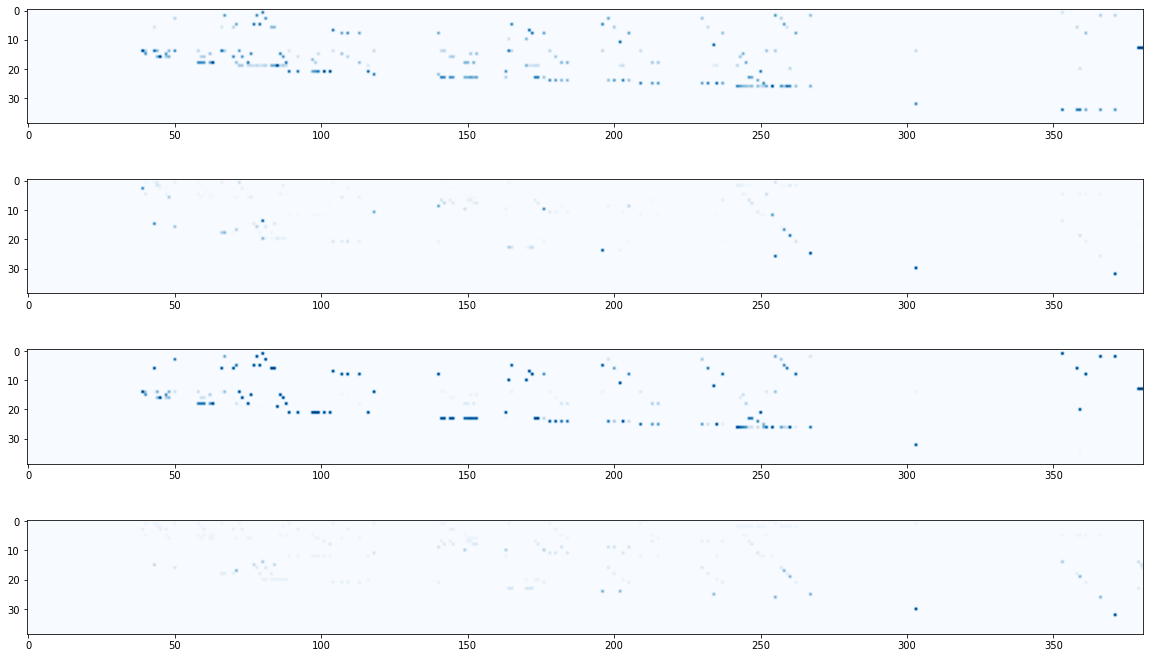

In [32]:
plt.figure(figsize=(20, 12))
plt.subplot(4, 1, 1)
plt.imshow(s2r_mat1, cmap='Blues')
plt.subplot(4, 1, 2)
plt.imshow(r2s_mat1.T, cmap='Blues')
plt.subplot(4, 1, 3)
plt.imshow(s2r_mat2, cmap='Blues')
plt.subplot(4, 1, 4)
plt.imshow(r2s_mat2.T, cmap='Blues')

In [33]:
# data
valid_dataset = SCDataset('../data', 'hydro', mode='test')
index = 0
x = valid_dataset[index].x
edge_index = valid_dataset[index].edge_index
edge_attr = valid_dataset[index].edge_attr
y = valid_dataset[index].y
y_index = valid_dataset[index].y_index
y_all = np.zeros((species_num, ), dtype=np.float32)
y_all[y_index] = 1

r2s_imp2 = np.dot(y_all / 100, r2s_mat2.T)
r2s_imp1 = np.dot(np.dot(r2s_imp2, s2r_mat2.T), r2s_mat1.T)

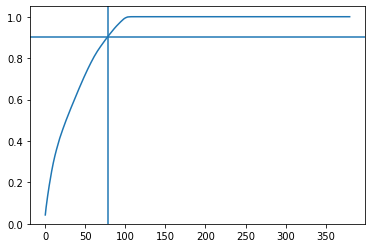

In [34]:
explained_ratio = 0.9

reaction_imp = r2s_imp1 + r2s_imp2
order = (-reaction_imp).argsort()
plt.plot(reaction_imp[order].cumsum() / reaction_imp.sum())
plt.axhline(explained_ratio)
plt.axvline(np.where(reaction_imp[order].cumsum() / reaction_imp.sum() > explained_ratio)[0][0])
plt.ylim(0.0, 1.05)
reserve_reaction_index2 = order[:np.where(reaction_imp[order].cumsum() / reaction_imp.sum() > explained_ratio)[0][0]]

In [35]:
reaction_cfg = configparser.ConfigParser()
reaction_cfg.read('../data/raw_dir/hydro/reactions.cfg')
for reaction_index in (reserve_reaction_index2 - 38):
    print(reaction_cfg.get('reaction_%d' % reaction_index, 'reaction'))
reserve_edge_bool2 = [i in reserve_reaction_index2 for i in edge_index.numpy().max(axis=0)]

C2H4+CH3J(14)>C2H3J(25)+CH4
CH4+HJ(15)>CH3J(14)+H2
C2H4+C2H3J(25)>C4H7J(24)
C2H4+CH3J(14)>C3H7J(18)
C3H8+CH3J(14)>C3H7J(17)+CH4
C3H8+CH3J(14)>C3H7J(18)+CH4
nC4H10+CH3J(14)>C4H9J(19)+CH4
C2H6+CH3J(14)>C2H5J(16)+CH4
C3H6+CH3J(14)>C4H9J(22)
BUT-2+C2H5J(16)>C4H7J(23)+C2H6
C2H3J(25)+BUT-2>C2H4+C4H7J(23)
BUT-2+C3H7J(17)>C4H7J(23)+C3H8
BUT-1+CH3J(14)>C4H7J(23)+CH4
CH3J(14)+C2H5J(16)>C3H8
CH3J(14)+CH3J(14)>C2H6
BUT-2+HJ(15)>C4H9J(19)
C2H4+HJ(15)>C2H5J(16)
BUT-2+C3H7J(18)>C4H7J(23)+C3H8
C2H6+HJ(15)>C2H5J(16)+H2
C2H5J(16)+C2H5J(16)>C2H4+C2H6
C3H6+CH3J(14)>C4H9J(19)
C4H7J(23)+C2H5J(16)>C4H6+C2H6
C3H7J(17)+C2H5J(16)>C3H6+C2H6
C4H9J(19)+BUT-2>nC4H10+C4H7J(23)
C3H7J(18)+C2H5J(16)>C3H6+C2H6
C2H5J(16)+CH3J(14)>C2H4+CH4
HJ(15)+C2H5J(16)>H2+C2H4
C2H5J(16)+C3H7J(18)>C2H4+C3H8
C4H7J(23)+HJ(15)>C4H6+H2
C4H7J(24)+HJ(15)>C4H6+H2
C4H9J(19)+CH3J(14)>BUT-2+CH4
C3H5J(27)+BUT-2>C3H6+C4H7J(23)
C2H3J(25)+H2>C2H4+HJ(15)
C3H8+HJ(15)>C3H7J(17)+H2
C3H7J(17)+C3H7J(18)>C3H6+C3H8
HJ(15)+C3H7J(17)>H2+C3H6
C4H9J(19)+C2H5J(1

# Simplification Step 2

In [43]:
# model
scnet = SCNet(10, 16, 9)

# dataset
train_dataset = SCDataset('../data', 'hydro')
train_loader = tg.data.DataLoader(train_dataset, 16, shuffle=True)
valid_dataset = SCDataset('../data', 'hydro', mode='test')
valid_loader = tg.data.DataLoader(valid_dataset, 16, shuffle=False)

# optimizer
optimizer = torch.optim.Adam(scnet.parameters(), lr=0.001, weight_decay=1e-6)

# train
train_losses = []
valid_losses = []
epochs = 20
tqdm_epoch = range(epochs)
for epoch in tqdm_epoch:
    train_losses.extend(train(scnet, train_loader, optimizer, reserve_edge_bool2))
    valid_losses.extend(valid(scnet, valid_loader, reserve_edge_bool2))
torch.save(scnet.state_dict(), '../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__2.ckpt')
json.dump({'train': train_losses, 'valid': valid_losses}, open('../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__2.log', 'w'))

100%|██████████| 32/32 [00:00<00:00, 52.15it/s, valid_loss=0.293]


(0.0, 2.0)

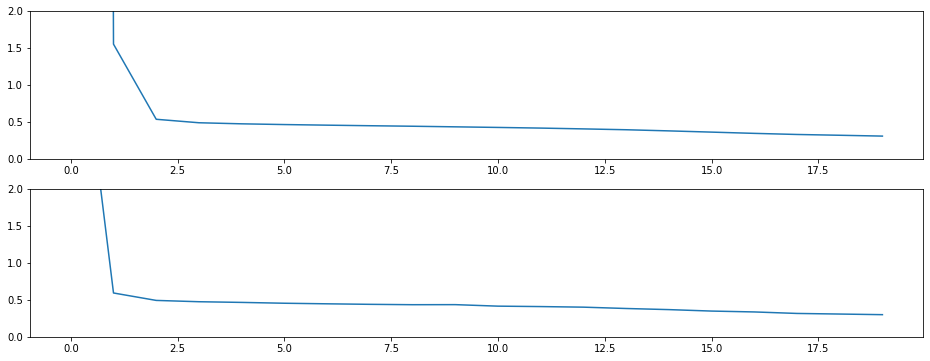

In [45]:
log = json.load(open('../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__2.log', 'r'))
train_losses, valid_losses = log['train'], log['valid']
plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.plot(np.array(train_losses).reshape(epochs, -1).mean(axis=-1), label='Training loss')
plt.ylim(0, 2)
plt.subplot(2, 1, 2)
plt.plot(np.array(valid_losses).reshape(epochs, -1).mean(axis=-1), label='Testing loss')
plt.ylim(0, 2)

In [44]:
np.array(valid_losses[-32:]).mean()

0.2985609592869878

In [46]:
# data
valid_dataset = SCDataset('../data', 'hydro', mode='test')

index = 0
x = valid_dataset[index].x
edge_index = valid_dataset[index].edge_index
edge_attr = valid_dataset[index].edge_attr
y = valid_dataset[index].y
y_index = valid_dataset[index].y_index

# model
scnet = SCNet(10, 16, 9)
scnet.load_state_dict(torch.load('../ckpt/scnet_lanzhou_wison_hydro_10_16_16_1__2.ckpt'))
x, (_, s2r_att1, s2r_pre_att1) = scnet.s2r_conv1.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)
x, (_, r2s_att1, r2s_pre_att1) = scnet.r2s_conv1.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)
x, (_, s2r_att2, s2r_pre_att2) = scnet.s2r_conv2.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)
x, (_, r2s_att2, r2s_pre_att2) = scnet.r2s_conv2.forward(x, edge_index[:, reserve_edge_bool1], edge_attr[reserve_edge_bool1], return_attention_weights=True)

In [47]:
species_num = len(valid_dataset.species_names)
reaction_num = len(x) - species_num

s2r_mat1 = np.zeros((species_num, species_num + reaction_num), dtype=np.float32)
r2s_mat1 = np.zeros((species_num + reaction_num, species_num), dtype=np.float32)
s2r_mat2 = np.zeros((species_num, species_num + reaction_num), dtype=np.float32)
r2s_mat2 = np.zeros((species_num + reaction_num, species_num), dtype=np.float32)

for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), s2r_att1.detach().numpy()):
    if src < dst:
        s2r_mat1[src, dst] = att
for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), r2s_att1.detach().numpy()):
    if src > dst:
        r2s_mat1[src, dst] = att
for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), s2r_att2.detach().numpy()):
    if src < dst:
        s2r_mat2[src, dst] = att
for (src, dst), att in zip(edge_index.transpose(1, 0)[reserve_edge_bool1].numpy(), r2s_att2.detach().numpy()):
    if src > dst:
        r2s_mat2[src, dst] = att

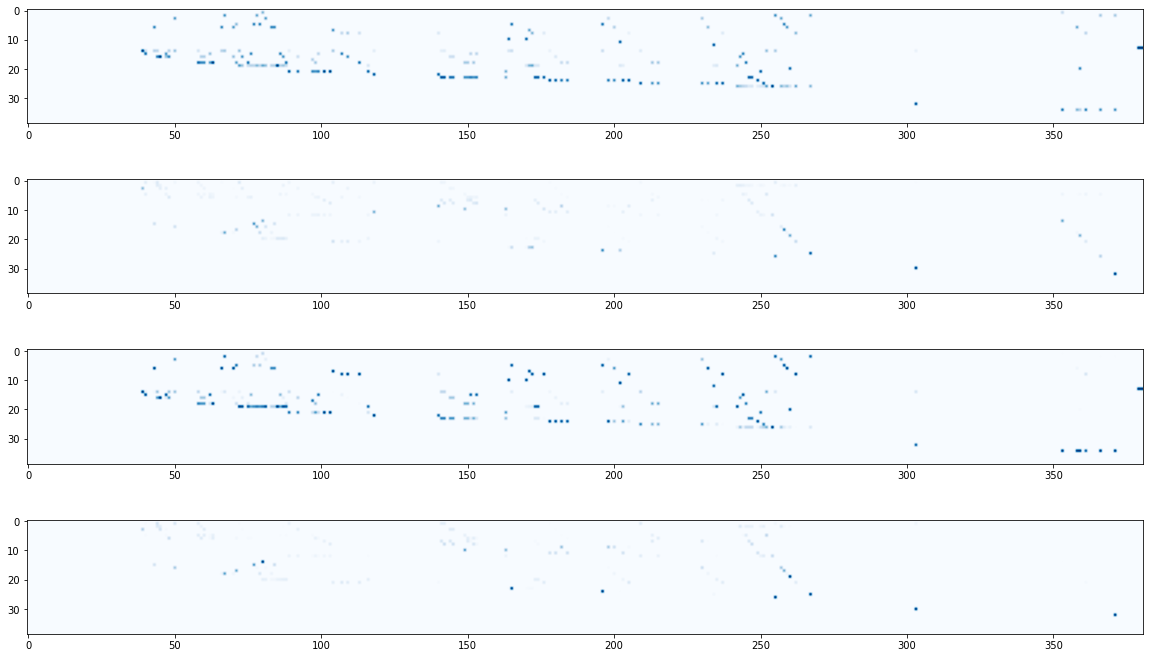

In [48]:
plt.figure(figsize=(20, 12))
plt.subplot(4, 1, 1)
plt.imshow(s2r_mat1, cmap='Blues')
plt.subplot(4, 1, 2)
plt.imshow(r2s_mat1.T, cmap='Blues')
plt.subplot(4, 1, 3)
plt.imshow(s2r_mat2, cmap='Blues')
plt.subplot(4, 1, 4)
plt.imshow(r2s_mat2.T, cmap='Blues')

In [49]:
# data
valid_dataset = SCDataset('../data', 'hydro', mode='test')
index = 0
x = valid_dataset[index].x
edge_index = valid_dataset[index].edge_index
edge_attr = valid_dataset[index].edge_attr
y = valid_dataset[index].y
y_index = valid_dataset[index].y_index
y_all = np.zeros((species_num, ), dtype=np.float32)
y_all[y_index] = 1

r2s_imp2 = np.dot(y_all / 100, r2s_mat2.T)
r2s_imp1 = np.dot(np.dot(r2s_imp2, s2r_mat2.T), r2s_mat1.T)

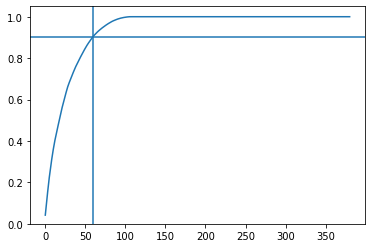

In [50]:
explained_ratio = 0.9

reaction_imp = r2s_imp1 + r2s_imp2
order = (-reaction_imp).argsort()
plt.plot(reaction_imp[order].cumsum() / reaction_imp.sum())
plt.axhline(explained_ratio)
plt.axvline(np.where(reaction_imp[order].cumsum() / reaction_imp.sum() > explained_ratio)[0][0])
plt.ylim(0.0, 1.05)
reserve_reaction_index2 = order[:np.where(reaction_imp[order].cumsum() / reaction_imp.sum() > explained_ratio)[0][0]]

In [53]:
reserve_reaction_index1[reserve_reaction_index1.argsort()] - 38

array([  1,   2,   5,   6,   7,   9,  10,  12,  20,  21,  22,  24,  25,
        28,  29,  32,  33,  34,  35,  37,  38,  39,  40,  41,  42,  43,
        45,  46,  47,  48,  49,  50,  51,  54,  59,  60,  61,  63,  65,
        66,  69,  71,  75,  78,  80, 102, 103, 104, 106, 107, 111, 112,
       113, 114, 115, 125, 126, 127, 132, 133, 134, 135, 136, 138, 140,
       142, 144, 146, 158, 160, 162, 164, 165, 167, 171, 175, 177, 192,
       194, 196, 197, 199, 204, 205, 206, 207, 208, 209, 211, 212, 213,
       214, 216, 217, 219, 220, 221, 222, 224, 229, 265, 315, 320, 321,
       323, 328, 333, 341, 342])